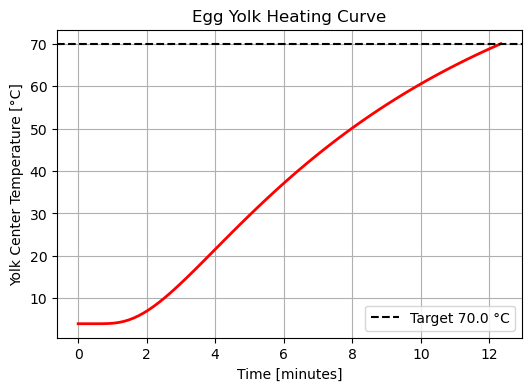

✅ Egg yolk center reached 70.0 °C at t ≈ 12.3 minutes


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# ======================= CONFIG (Egg geometry & properties) =======================
R_total = 0.025        # [m] total egg radius (~25 mm)
R_yolk  = 0.010        # [m] yolk radius (~10 mm)

Nx = 201               # radial grid points
dx = R_total/(Nx-1)

# White (albumen) properties
k_w, rho_w, cp_w = 0.85, 1030.0, 1900.0
# Yolk properties
k_y, rho_y, cp_y = 0.65, 1040.0, 1500.0

# Initial & boundary conditions
T_initial = 4.0
T_surface = 100.0
T_target  = 70.0  # stop when yolk center reaches this

# Time step
r = np.linspace(0, R_total, Nx)
mask_yolk = r <= R_yolk
k_arr   = np.where(mask_yolk, k_y, k_w)
rho_arr = np.where(mask_yolk, rho_y, rho_w)
cp_arr  = np.where(mask_yolk, cp_y, cp_w)
vol     = rho_arr*cp_arr

# Precompute harmonic means of k
kL = np.zeros(Nx)
kR = np.zeros(Nx)
kL[1:] = 2*k_arr[1:]*k_arr[:-1]/(k_arr[1:]+k_arr[:-1])
kR[:-1] = 2*k_arr[:-1]*k_arr[1:]/(k_arr[:-1]+k_arr[1:])

alpha_max = np.max(k_arr/(rho_arr*cp_arr))
dt_max = dx**2/(2*alpha_max)
dt = 0.49*dt_max
max_time = 4000.0   # [s] simulate up to 30 min
n_steps = int(np.ceil(max_time/dt))

# Animation controls
frame_stride = 1000
Ngrid = 150  # resolution of circular projection
colormap_name = "plasma"
# ================================================================================

# Initial condition
T = np.full(Nx, T_initial, dtype=float)
snap2D, times, mids = [], [0.0], [T[0]]
fuse_time = None

# Prepare grid for circular projection
xx, yy = np.meshgrid(np.linspace(-R_total, R_total, Ngrid),
                     np.linspace(-R_total, R_total, Ngrid))
rr = np.sqrt(xx**2 + yy**2)
mask_inside = rr <= R_total

# Simulation
for n in range(1, n_steps+1):
    dT = np.zeros_like(T)
    dT[1:-1] = (kR[1:-1]*(T[2:] - T[1:-1]) - kL[1:-1]*(T[1:-1] - T[:-2])) / dx**2
    Tn = T + (dt/vol)*dT

    # BCs
    Tn[0]  = Tn[1]       # Neumann at center
    Tn[-1] = T_surface   # Dirichlet at shell
    T = Tn

    if n % frame_stride == 0 or n == n_steps:
        # project 1D profile onto 2D circular map
        Tmap = np.full_like(rr, np.nan, dtype=float)
        Tmap[mask_inside] = np.interp(rr[mask_inside], r, T)
        snap2D.append(Tmap)
        times.append(n*dt)
        mids.append(T[0])

    if T[0] >= T_target:
        fuse_time = n*dt
        Tmap = np.full_like(rr, np.nan, dtype=float)
        Tmap[mask_inside] = np.interp(rr[mask_inside], r, T)
        snap2D.append(Tmap)
        times.append(n*dt)
        mids.append(T[0])
        break

# ---------------------- Animation ----------------------
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(snap2D[0], extent=[-R_total*1000,R_total*1000,-R_total*1000,R_total*1000],
               origin='lower', cmap=colormap_name, vmin=T_initial, vmax=T_surface)
cb = plt.colorbar(im, ax=ax)
cb.set_label("Temperature [°C]")

# Egg outline
circle_egg = plt.Circle((0,0), R_total*1000, fill=False, color='k', lw=2)
ax.add_artist(circle_egg)
# Yolk boundary
circle_yolk = plt.Circle((0,0), R_yolk*1000, fill=False, color='yellow', lw=2, ls='--')
ax.add_artist(circle_yolk)

ax.set_aspect('equal')
ax.set_xlabel("mm")
ax.set_ylabel("mm")
time_txt = ax.text(0.02, 0.95, "", transform=ax.transAxes, va="top", color="w")

def init():
    im.set_data(snap2D[0])
    time_txt.set_text(f"t = {times[0]:.1f} s, Center: {mids[0]:.1f} °C")
    return im, time_txt

def update(i):
    im.set_data(snap2D[i])
    time_txt.set_text(f"t = {times[i]:.1f} s, Center: {mids[i]:.1f} °C")
    return im, time_txt

ani = FuncAnimation(fig, update, frames=len(snap2D),
                    init_func=init, blit=True, interval=120)
plt.close(fig)
display(HTML(ani.to_jshtml()))

# ------------------ Center T vs time -------------------
plt.figure(figsize=(6,4))
plt.plot(np.array(times)/60, mids, 'r-', lw=2)
plt.axhline(T_target, color='k', ls='--', label=f"Target {T_target} °C")
plt.xlabel("Time [minutes]")
plt.ylabel("Yolk Center Temperature [°C]")
plt.title("Egg Yolk Heating Curve")
plt.grid(True)
plt.legend()
plt.show()

if fuse_time:
    print(f"✅ Egg yolk center reached {T_target} °C at t ≈ {fuse_time/60:.1f} minutes")
else:
    print("⚠️ Target not reached within max_time")
